## Import Some Relevant Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
import functools
import sys

In [2]:
tf.__version__

'2.3.0'

In [3]:
print(sys.version)

3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]


## Import Content and Style Images as Tensors

In [4]:
def load_img(path_to_image):
    max_dimension = 512

    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dimension/long_dim

    new_shape = tf.cast(shape*scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)

    if title:
        plt.title(title)

## Lets see how they look

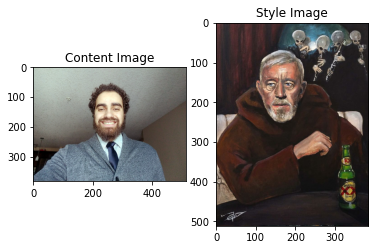

In [6]:
style_path = 'style_pic.jpg'
content_path = 'picture_of_me.jpeg'

style_image = load_img(style_path)
content_image = load_img(content_path)

plt.subplot(1, 2, 1)
imshow(content_image, title='Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, title='Style Image')

## Lets Import VGG to use as the Neural Network for Our Style Transfer

Again, thanks a lot Google

In [7]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))

vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [8]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('suit', 0.47692928),
 ('Windsor_tie', 0.08282356),
 ('bolo_tie', 0.06230833),
 ('bassoon', 0.029699685),
 ('cardigan', 0.027762096)]

In [9]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


## Lets use a relatively Deep Layer to Assess Content Likeness (So it can pick up on higher level Features) and a few other layers for the style likeness

In [10]:
content_layers = ['block5_conv2']

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

number_content_layers = len(content_layers)
number_style_layers = len(style_layers)

In [11]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)

    return model

In [12]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print('shape:', output.numpy().shape)
    print('min:', output.numpy().min())
    print('max:', output.numpy().max())
    print('mean:', output.numpy().mean())
    print()

block1_conv1
shape: (1, 512, 384, 64)
min: 0.0
max: 827.52124
mean: 13.7656975

block2_conv1
shape: (1, 256, 192, 128)
min: 0.0
max: 3983.2944
mean: 78.73566

block3_conv1
shape: (1, 128, 96, 256)
min: 0.0
max: 6372.444
mean: 83.84401

block4_conv1
shape: (1, 64, 48, 512)
min: 0.0
max: 14558.9795
mean: 375.34286

block5_conv1
shape: (1, 32, 24, 512)
min: 0.0
max: 3256.6501
mean: 38.889614



## Now lets define the Loss Function

## Now Lets Make the Loss function for Style and Content

We'll need Gram Matrices to assess the likeness of channels to each other (style likeness)

In [13]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)

    return result/(num_locations)

### Extract Style and content values from our Generated Image 

In [14]:
class style_content_model(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(style_content_model, self).__init__()
        self.vgg = vgg_layers(style_layers+content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255
        preproccess_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preproccess_input)
        style_outputs, content_outputs = (
            outputs[:self.num_style_layers],
            outputs[self.num_style_layers:]
        )

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {
            content_name:value
            for content_name, value 
            in zip(self.style_layers, content_outputs)
        }

        style_dict = {
            style_name:value
            for style_name, value
            in zip(self.style_layers, style_outputs)
        }

        return {'content':content_dict, 'style':style_dict}

In [15]:
extractor = style_content_model(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print(name)
    print('shape:', output.numpy().shape)
    print('min:', output.numpy().min())
    print('max:', output.numpy().max())
    print('mean', output.numpy().mean())
    print()

print('Contents:')
for name, output in sorted(results['content'].items()):
    print(name)
    print('shape:', output.numpy().shape)
    print('min:', output.numpy().min())
    print('max:', output.numpy().max())
    print('mean', output.numpy().mean())
    print()

Styles:
block1_conv1
shape: (1, 64, 64)
min: 0.007600302
max: 16821.02
mean 288.6435

block2_conv1
shape: (1, 128, 128)
min: 0.0
max: 76708.055
mean 8856.862

block3_conv1
shape: (1, 256, 256)
min: 0.0
max: 177770.12
mean 7574.785

block4_conv1
shape: (1, 512, 512)
min: 2.5118446
max: 2193182.2
mean 140558.34

block5_conv1
shape: (1, 512, 512)
min: 0.0
max: 136494.55
mean 1355.47

Contents:
block1_conv1
shape: (1, 24, 32, 512)
min: 0.0
max: 1499.4686
mean 12.078469



In [16]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

In [17]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [18]:
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [19]:
style_weight = 1e-2
content_weight= 1e4

### Now lets compare the Generated Image to the Content of the Content image and the style of the Style Image

In [20]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
        for name in style_outputs.keys()
        ])

    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
        for name in content_outputs.keys()
        ])

    content_loss *= content_weight/number_content_layers

    loss = style_loss + content_loss

    return loss 

## Now let's make sure Tensorflow preforms gradient descent on the pixels of the generated image

In [21]:
@tf.function()

def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [22]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)

    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    
    return PIL.Image.fromarray(tensor)

## Sanity Check to make sure it's working

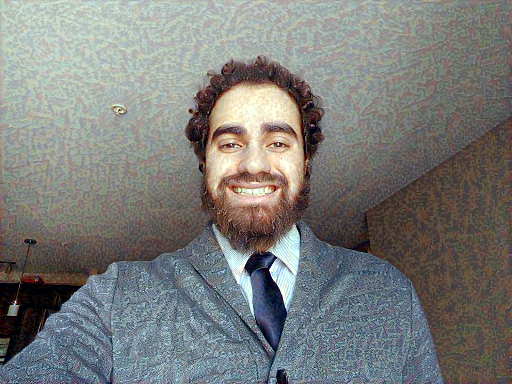

In [23]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

## Now Lets Train it for Real

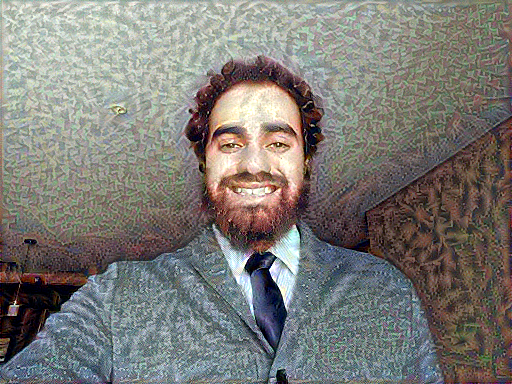

Train step: 10
Total time: 27.1


In [24]:
import IPython.display as display

start = time.time()

epochs = 10
steps_per_epoch = 1

step = 0

for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print('.', end='')

        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print('Train step: {}'.format(step))

end = time.time()
print('Total time: {:.1f}'.format(end-start))

## Now let's Save this Beauty

In [25]:
file_name = 'generated_image.png'
tensor_to_image(image).save(file_name)

## Now lets compare all three

With the help of our old helper functions

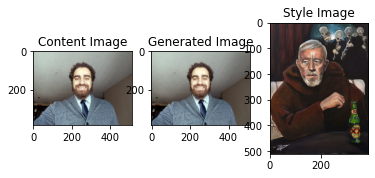

In [27]:
generated_path = 'generated_image.png'

style_image = load_img(style_path)
content_image = load_img(content_path)
generate_image = load_img(generated_path)

plt.subplot(1, 3, 1)
imshow(content_image, title='Content Image')

plt.subplot(1, 3, 2)
imshow(content_image, title='Generated Image')

plt.subplot(1, 3, 3)
imshow(style_image, title='Style Image')